In [1]:

import pandas as pd

file_path = "vectors_syscallsbinders_frequency_5_Cat.csv"  
df = pd.read_csv(file_path)


print("Dataset Shape:", df.shape)
df.head()  # Show first 5 rows


Dataset Shape: (11598, 471)


,ACCESS_PERSONAL_INFO___,ALTER_PHONE_STATE___,ANTI_DEBUG_____,CREATE_FOLDER_____,CREATE_PROCESS`_____,CREATE_THREAD_____,DEVICE_ACCESS_____,EXECUTE_____,FS_ACCESS____,FS_ACCESS()____,...,utimes,vfork,vibrate,vibratePattern,wait4,watchRotation,windowGainedFocus,write,writev,Class
0,1,0,0,3,0,14,2,0,3,0,...,0,0,0,0,0,0,0,37,10,1
1,3,0,0,6,0,42,91,0,32,0,...,0,0,0,0,0,0,2,2838,46,1
2,2,0,0,4,0,23,3,0,17,2,...,0,0,0,0,0,0,1,111,20,1
3,1,0,0,4,0,27,9,0,36,0,...,0,0,0,0,0,0,7,987,197,1
4,3,0,0,11,0,18,3,0,16,0,...,0,0,0,0,0,0,1,98,25,1


In [2]:

missing_values = df.isnull().sum()

# Print columns with missing values (if any)
missing_values[missing_values > 0]


Series([], dtype: int64)

In [6]:
# Count duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Remove duplicates if found
df = df.drop_duplicates()

# Verify dataset shape after removal
print("New Dataset Shape:", df.shape)


Number of duplicate rows: 72
New Dataset Shape: (11526, 471)


In [7]:
# Identify zero-variance columns (where all values are the same)
zero_variance_cols = df.columns[df.nunique() == 1]

# Drop them from the dataset
df = df.drop(columns=zero_variance_cols)

# Print results
print(f"Removed {len(zero_variance_cols)} zero-variance features.")
print("New dataset shape:", df.shape)


Removed 0 zero-variance features.
New dataset shape: (11526, 471)


In [8]:
import numpy as np

# Compute correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation higher than 0.95
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop the highly correlated features
df = df.drop(columns=high_corr_features)

# Print results
print(f"Removed {len(high_corr_features)} highly correlated features.")
print("New dataset shape:", df.shape)


Removed 79 highly correlated features.
New dataset shape: (11526, 392)


In [9]:
import pandas as pd

# Assuming your cleaned DataFrame is named `df_clean`
df.to_csv('clean_dataset_malware2.csv', index=False)


In [19]:
# Load the cleaned dataset
df = pd.read_csv('clean_dataset_malware2.csv')

# Assume the original label column is named 'label'
def map_labels(label):
    if label in [1, 2, 3, 4]:
        return 1  # Malware
    elif label == 5:
        return 0  # Benign
    else:
        return None  # In case of unexpected values

df['binary_label'] = df['Class'].apply(map_labels)

# Drop rows with None if any
df = df.dropna(subset=['binary_label'])
print(df['binary_label'].value_counts())


binary_label
1    9734
0    1792
Name: count, dtype: int64


In [11]:
from sklearn.preprocessing import StandardScaler

# Assume your features are in df.drop(['label', 'binary_label'], axis=1)
X = df.drop(['Class', 'binary_label'], axis=1)
y = df['binary_label']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

estimator = LogisticRegression(random_state=42, max_iter=1000)
# Using StratifiedKFold for a classification problem
cv = StratifiedKFold(5)
rfecv = RFECV(estimator, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X_scaled, y)  # X_scaled: your scaled features

score_lr = rfecv.grid_scores_.mean() if hasattr(rfecv, 'grid_scores_') else rfecv.score(X_scaled, y)
print("\nRFECV with LogisticRegression - Best CV score:", score_lr)

print("Optimal number of features: %d" % rfecv.n_features_)


Optimal number of features: 110


In [17]:
# Use RFECV to transform the features to only the optimal ones
X_optimal = rfecv.transform(X_scaled)
print("Shape after RFECV transformation:", X_optimal.shape)

Shape after RFECV transformation: (11526, 110)


In [18]:
from sklearn.model_selection import train_test_split

X_train_opt, X_test_opt, y_train, y_test = train_test_split(
    X_optimal, y, test_size=0.2, random_state=42, stratify=y
)


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(random_state=42, max_iter=1000)
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],  # l1 requires solvers that support it; so we use l2.
    'solver': ['lbfgs']
}

grid_lr = GridSearchCV(lr, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_opt, y_train)
print("Best parameters for Logistic Regression:", grid_lr.best_params_)
evaluate_model(grid_lr.best_estimator_, X_test_opt, y_test)


Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.9627059843885516
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87       359
           1       0.97      0.99      0.98      1947

    accuracy                           0.96      2306
   macro avg       0.96      0.90      0.92      2306
weighted avg       0.96      0.96      0.96      2306

ROC-AUC: 0.9669386371147385


In [58]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_opt, y_train)
print("Best parameters for Random Forest:", grid_rf.best_params_)
evaluate_model(grid_rf.best_estimator_, X_test_opt, y_test)


Best parameters for Random Forest: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9744145706851691
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.91       359
           1       0.98      0.99      0.98      1947

    accuracy                           0.97      2306
   macro avg       0.97      0.94      0.95      2306
weighted avg       0.97      0.97      0.97      2306

ROC-AUC: 0.9951421585669261


In [59]:
from sklearn.svm import SVC

svm = SVC(probability=True, random_state=42)
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(svm, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_opt, y_train)
print("Best parameters for SVM:", grid_svm.best_params_)
evaluate_model(grid_svm.best_estimator_, X_test_opt, y_test)


Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.9635732870771899
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.81      0.87       359
           1       0.97      0.99      0.98      1947

    accuracy                           0.96      2306
   macro avg       0.96      0.90      0.93      2306
weighted avg       0.96      0.96      0.96      2306

ROC-AUC: 0.9624913980940608


In [60]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train_opt, y_train)
print("Best parameters for KNN:", grid_knn.best_params_)
evaluate_model(grid_knn.best_estimator_, X_test_opt, y_test)


Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Accuracy: 0.9570685169124025
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.79      0.85       359
           1       0.96      0.99      0.97      1947

    accuracy                           0.96      2306
   macro avg       0.94      0.89      0.91      2306
weighted avg       0.96      0.96      0.96      2306

ROC-AUC: 0.9369911284126855


In [61]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

# Create results dictionary using the optimal data (X_test_opt)
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'KNN'],
    'Accuracy': [
        accuracy_score(y_test, grid_lr.best_estimator_.predict(X_test_opt)),
        accuracy_score(y_test, grid_rf.best_estimator_.predict(X_test_opt)),
        accuracy_score(y_test, grid_svm.best_estimator_.predict(X_test_opt)),
        accuracy_score(y_test, grid_knn.best_estimator_.predict(X_test_opt))
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, grid_lr.best_estimator_.predict_proba(X_test_opt)[:, 1]),
        roc_auc_score(y_test, grid_rf.best_estimator_.predict_proba(X_test_opt)[:, 1]),
        roc_auc_score(y_test, grid_svm.best_estimator_.predict_proba(X_test_opt)[:, 1]),
        roc_auc_score(y_test, grid_knn.best_estimator_.predict_proba(X_test_opt)[:, 1])
    ]
}

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy   ROC-AUC
0  Logistic Regression  0.962706  0.966939
1        Random Forest  0.974415  0.995142
2                  SVM  0.963573  0.962491
3                  KNN  0.957069  0.936991


In [65]:
from sklearn.ensemble import VotingClassifier

# Assign weights based on performance (you can adjust these based on experiments)
# For example: Random Forest (weight=3), Logistic Regression (weight=2), SVM (weight=2), KNN (weight=1)
voting_clf = VotingClassifier(estimators=[
    ('lr', grid_lr.best_estimator_),
    ('rf', grid_rf.best_estimator_),
    ('svm', grid_svm.best_estimator_)
], voting='soft', weights=[1, 2, 1])

voting_clf.fit(X_train_opt, y_train)
print("Voting Classifier Accuracy:", accuracy_score(y_test, voting_clf.predict(X_test_opt)))
print("Voting Classifier ROC-AUC:", roc_auc_score(y_test, voting_clf.predict_proba(X_test_opt)[:, 1]))


Voting Classifier Accuracy: 0.9674761491760624
Voting Classifier ROC-AUC: 0.9947036580812134


In [76]:
import time

# Measure inference time for a single sample (or a batch)
start_time = time.time()
_ = voting_clf.predict(X_test_opt[:110])  # Predict on a small batch
inference_time = time.time() - start_time
print("Inference Time for 10 samples:", inference_time, "seconds")


Inference Time for 10 samples: 0.03700852394104004 seconds


In [89]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('lr', grid_lr.best_estimator_),
    ('rf', grid_rf.best_estimator_),
    ('svm', grid_svm.best_estimator_)
], voting='soft')

# Fit the ensemble model on the optimal feature training data
voting_clf.fit(X_train_opt, y_train)

# Evaluate the Voting Classifier on the optimal test set
voting_accuracy = accuracy_score(y_test, voting_clf.predict(X_test_opt))
voting_roc_auc = roc_auc_score(y_test, voting_clf.predict_proba(X_test_opt)[:, 1])

print("Voting Classifier Accuracy (Optimal Features):", voting_accuracy)
print("Voting Classifier ROC-AUC (Optimal Features):", voting_roc_auc)

Voting Classifier Accuracy (Optimal Features): 0.9648742411101474
Voting Classifier ROC-AUC (Optimal Features): 0.9934360840833623


In [34]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        print("ROC-AUC:", roc_auc_score(y_test, y_proba))


In [90]:
import pandas as pd

# Define the performance data from your experiments
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'KNN'],
    'Accuracy': [0.962706, 0.974415, 0.963573, 0.957069],
    'ROC-AUC': [0.966939, 0.995142, 0.962491, 0.936991]
}

results_df = pd.DataFrame(data)
print(results_df)


                 Model  Accuracy   ROC-AUC
0  Logistic Regression  0.962706  0.966939
1        Random Forest  0.974415  0.995142
2                  SVM  0.963573  0.962491
3                  KNN  0.957069  0.936991


C:\Users\archi\AppData\Local\Temp\ipykernel_20528\68935889.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')


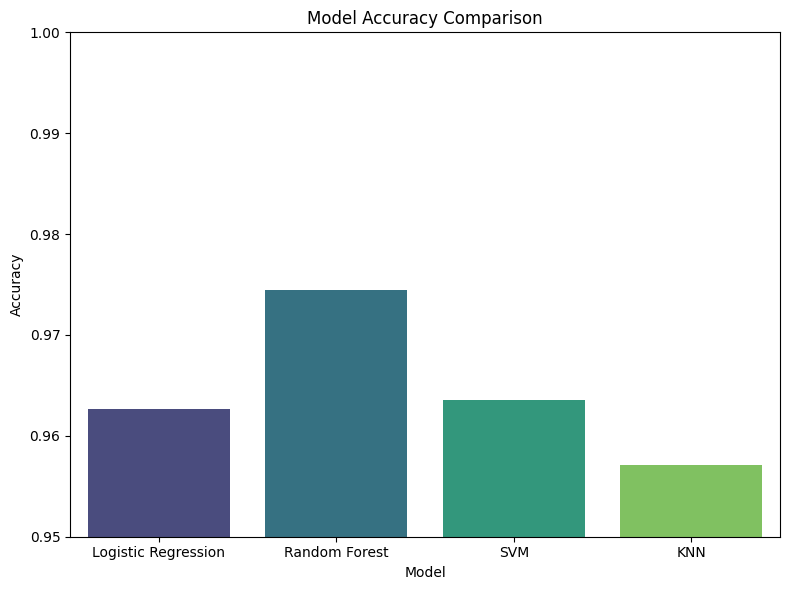

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.95, 1.0)  # Adjust the y-axis range if needed
plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=300)
plt.show()


C:\Users\archi\AppData\Local\Temp\ipykernel_20528\523836712.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='ROC-AUC', data=results_df, palette='plasma')


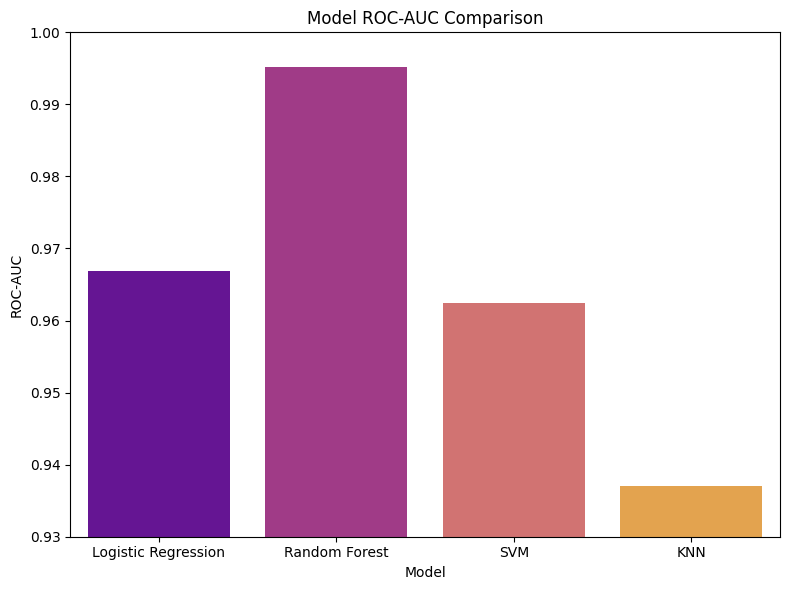

In [92]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='ROC-AUC', data=results_df, palette='plasma')
plt.title('Model ROC-AUC Comparison')
plt.xlabel('Model')
plt.ylabel('ROC-AUC')
plt.ylim(0.93, 1.0)  # Adjust the y-axis range if needed
plt.tight_layout()
plt.savefig("roc_auc_comparison.png", dpi=300)
plt.show()


In [94]:
# Define best parameters for each model as strings
params_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'KNN'],
    'Best Parameters': [
        "{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",
        "{'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}",
        "{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",
        "{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}"
    ]
}

params_df = pd.DataFrame(params_data)
print(params_df)


                 Model                                    Best Parameters
0  Logistic Regression      {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
1        Random Forest  {'max_depth': 30, 'min_samples_split': 2, 'n_e...
2                  SVM    {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
3                  KNN  {'metric': 'manhattan', 'n_neighbors': 3, 'wei...


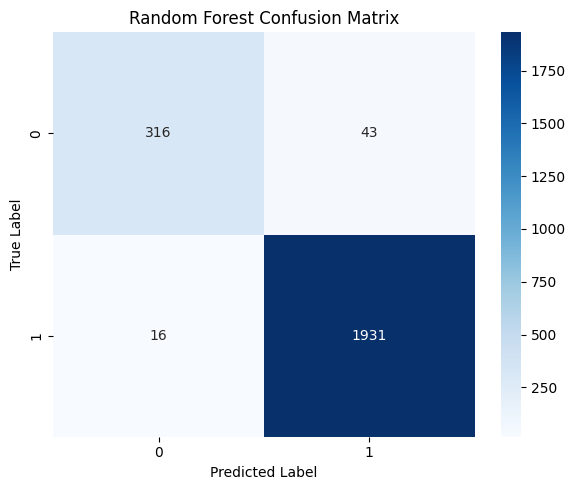

In [97]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

rf_pred = grid_rf.best_estimator_.predict(X_test_opt)
cm_rf = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig("rf_confusion_matrix.png", dpi=300)
plt.show()


C:\Users\archi\AppData\Local\Temp\ipykernel_20528\4084288375.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='ROC-AUC', data=results_df, palette='plasma')


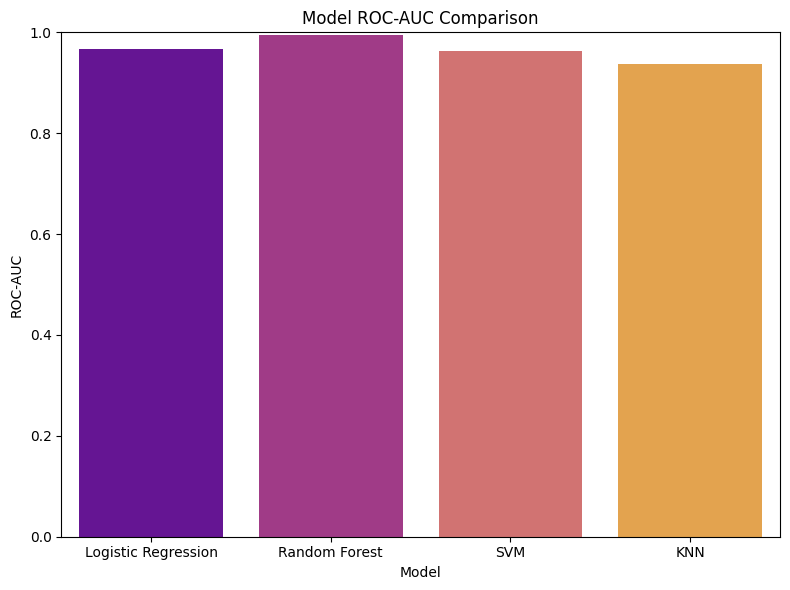

In [81]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='ROC-AUC', data=results_df, palette='plasma')
plt.title('Model ROC-AUC Comparison')
plt.ylim(0, 1)
plt.ylabel('ROC-AUC')
plt.xlabel('Model')
plt.tight_layout()
plt.savefig("roc_auc_comparison.png", dpi=300)
plt.show()


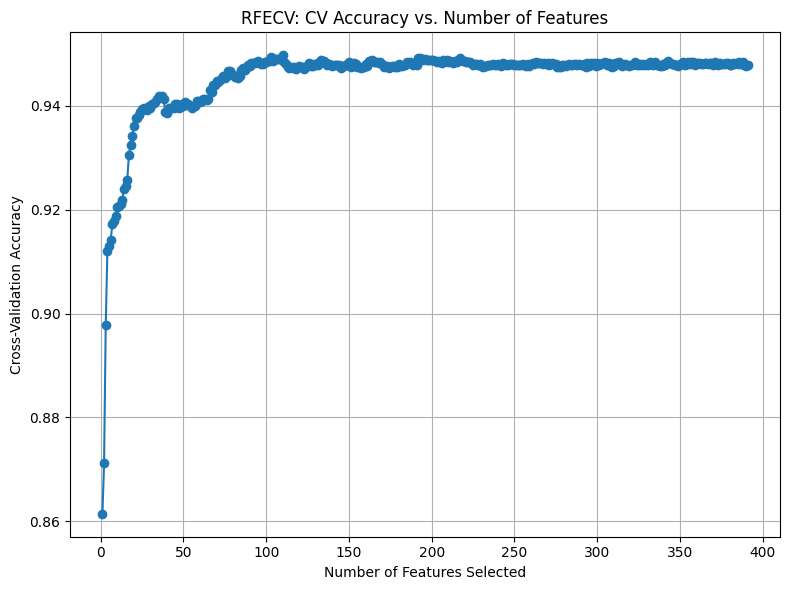

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Get the cross-validation scores from cv_results_
cv_scores = rfecv.cv_results_['mean_test_score']
n_features = range(1, len(cv_scores) + 1)

plt.figure(figsize=(8, 6))
plt.plot(n_features, cv_scores, marker='o', linestyle='-')
plt.title('RFECV: CV Accuracy vs. Number of Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.tight_layout()
plt.savefig("rfecv_lineplot.png", dpi=300)
plt.show()


C:\Users\archi\AppData\Local\Temp\ipykernel_20528\10957890.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Number of Features', y='CV Accuracy', data=rfecv_results_df, palette='coolwarm')


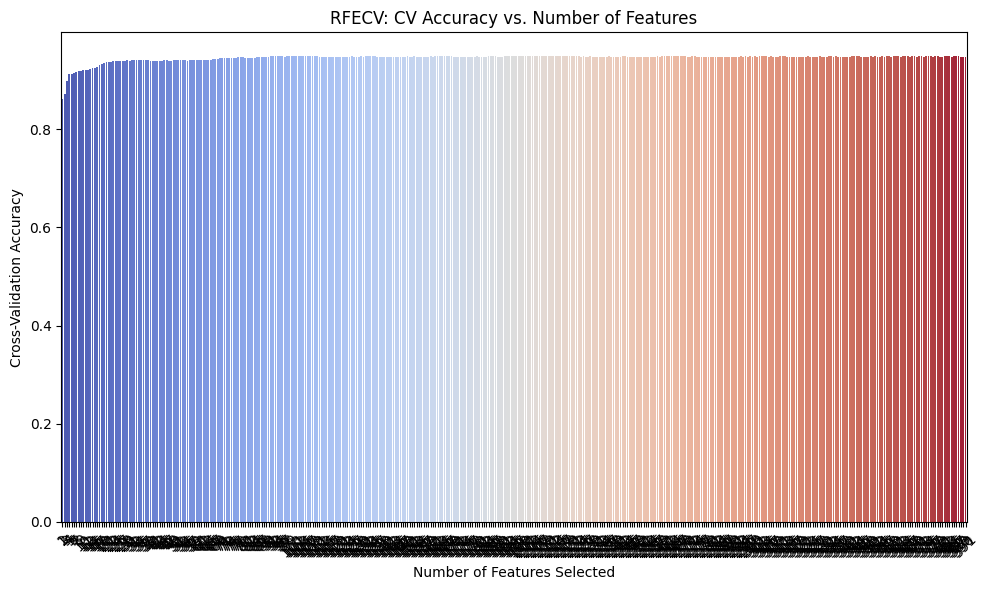

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the same DataFrame 'rfecv_results_df' from Example 1

plt.figure(figsize=(10, 6))
sns.barplot(x='Number of Features', y='CV Accuracy', data=rfecv_results_df, palette='coolwarm')
plt.title('RFECV: CV Accuracy vs. Number of Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validation Accuracy')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed for clarity
plt.tight_layout()
plt.savefig("rfecv_results_bar_chart.png", dpi=300)
plt.show()


In [108]:
import pandas as pd

# Example values: Replace these with your actual numbers from your preprocessing steps.
# For instance:
# - Initial Data: 3000 rows, 1000 columns
# - After Duplicate Removal: 2900 rows, 1000 columns
# - After Zero-Variance Removal: 2900 rows, 920 columns
# - After Correlation Filter (and removal of unnecessary columns): 2900 rows, 880 columns

preprocessing_summary = {
    'Step': [
        'Initial Data', 
        'After Duplicate Removal', 
        'After Zero-Variance Removal', 
        'After Correlation Filter'
    ],
    'Row Count': [11598, 11526, 11526, 11526],
    'Column Count': [471, 471, 471, 392]
}

preprocessing_df = pd.DataFrame(preprocessing_summary)
print(preprocessing_df)



                          Step  Row Count  Column Count
0                 Initial Data      11598           471
1      After Duplicate Removal      11526           471
2  After Zero-Variance Removal      11526           471
3     After Correlation Filter      11526           392


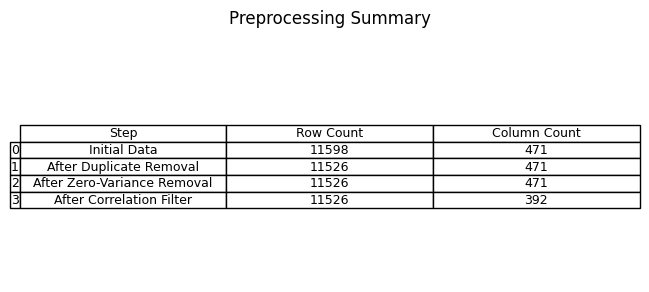

In [109]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Assuming preprocessing_df is already defined with 'Step', 'Row Count', and 'Column Count'
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create the table and set font sizes for better readability
tbl = table(ax, preprocessing_df, loc='center', cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)

plt.title('Preprocessing Summary', pad=20)
plt.savefig("preprocessing_summary.png", dpi=300, bbox_inches='tight')
plt.show()



In [86]:
hyperparams = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'KNN'],
    'Best Parameters': [
        grid_lr.best_params_,  # e.g., {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
        grid_rf.best_params_,  # e.g., {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2}
        grid_svm.best_params_, # e.g., {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}
        grid_knn.best_params_  # e.g., {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}
    ]
}

hyperparams_df = pd.DataFrame(hyperparams)
print(hyperparams_df)


                 Model                                    Best Parameters
0  Logistic Regression      {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
1        Random Forest  {'max_depth': 30, 'min_samples_split': 2, 'n_e...
2                  SVM    {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
3                  KNN  {'metric': 'manhattan', 'n_neighbors': 3, 'wei...


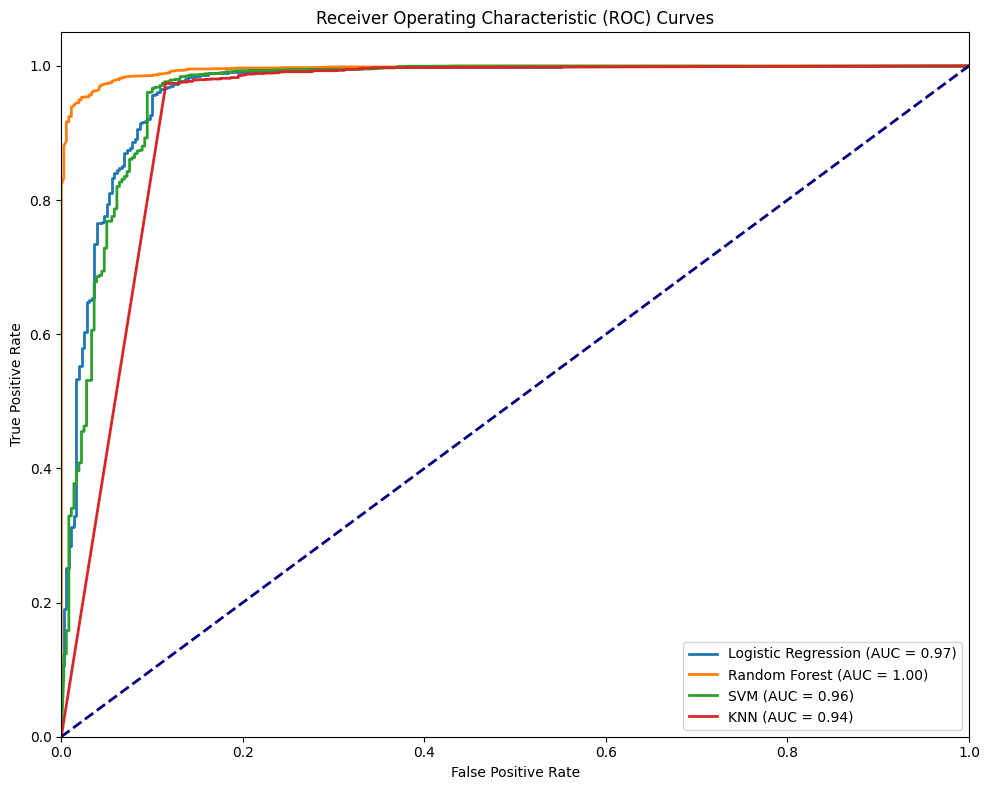

In [87]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

models = {
    'Logistic Regression': grid_lr.best_estimator_,
    'Random Forest': grid_rf.best_estimator_,
    'SVM': grid_svm.best_estimator_,
    'KNN': grid_knn.best_estimator_
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_opt)[:, 1]
    else:
        # Some classifiers use decision_function instead
        y_proba = model.decision_function(X_test_opt)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("roc_curves.png", dpi=300)
plt.show()


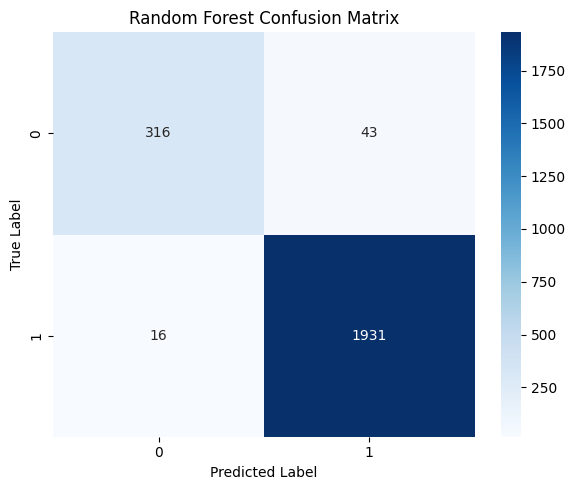

In [88]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Example for Random Forest
rf_pred = grid_rf.best_estimator_.predict(X_test_opt)
cm_rf = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig("rf_confusion_matrix.png", dpi=300)
plt.show()


In [98]:
import pandas as pd

# Define the macro-averaged metrics for each model (these numbers are taken from your classification reports)
metrics_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'KNN'],
    'Precision (Macro Avg)': [0.96, 0.97, 0.96, 0.94],
    'Recall (Macro Avg)': [0.90, 0.94, 0.90, 0.89],
    'F1-Score (Macro Avg)': [0.92, 0.95, 0.93, 0.91],
    'Support': [2306, 2306, 2306, 2306]
}

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)


                 Model  Precision (Macro Avg)  Recall (Macro Avg)  \
0  Logistic Regression                   0.96                0.90   
1        Random Forest                   0.97                0.94   
2                  SVM                   0.96                0.90   
3                  KNN                   0.94                0.89   

   F1-Score (Macro Avg)  Support  
0                  0.92     2306  
1                  0.95     2306  
2                  0.93     2306  
3                  0.91     2306  


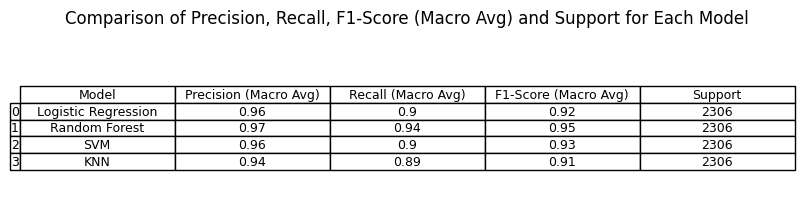

In [101]:
import matplotlib.pyplot as plt
from pandas.plotting import table

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
table_plot = table(ax, metrics_df, loc='center', cellLoc='center')
table_plot.auto_set_font_size(False)
table_plot.set_fontsize(9)
plt.title("Comparison of Precision, Recall, F1-Score (Macro Avg) and Support for Each Model", pad=20)
plt.savefig("model_comparison_table.png", dpi=300, bbox_inches='tight')
plt.show()


C:\Users\archi\AppData\Local\Temp\ipykernel_20528\4226925831.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Precision (Macro Avg)', data=metrics_df, palette='viridis')


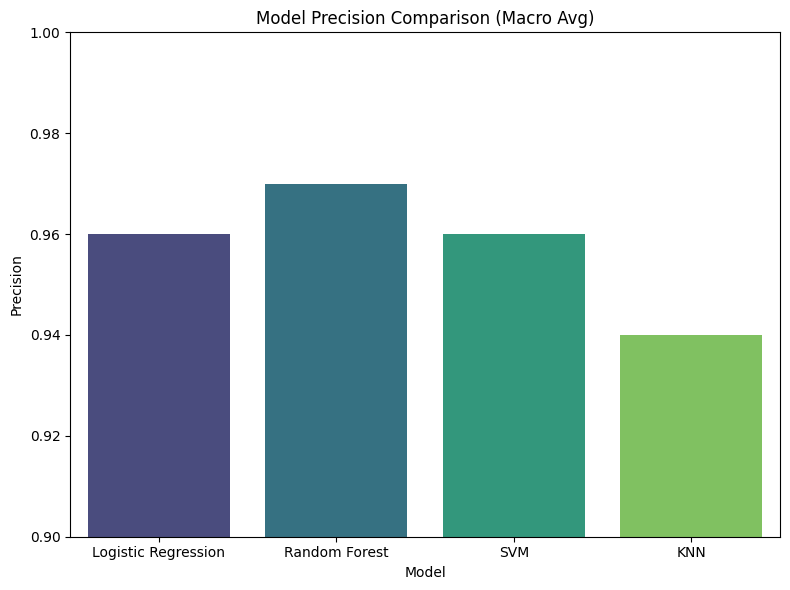

In [102]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Precision (Macro Avg)', data=metrics_df, palette='viridis')
plt.title('Model Precision Comparison (Macro Avg)')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.ylim(0.90, 1.0)  # Adjust as needed
plt.tight_layout()
plt.savefig("precision_comparison.png", dpi=300)
plt.show()


C:\Users\archi\AppData\Local\Temp\ipykernel_20528\3374245719.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall (Macro Avg)', data=metrics_df, palette='plasma')


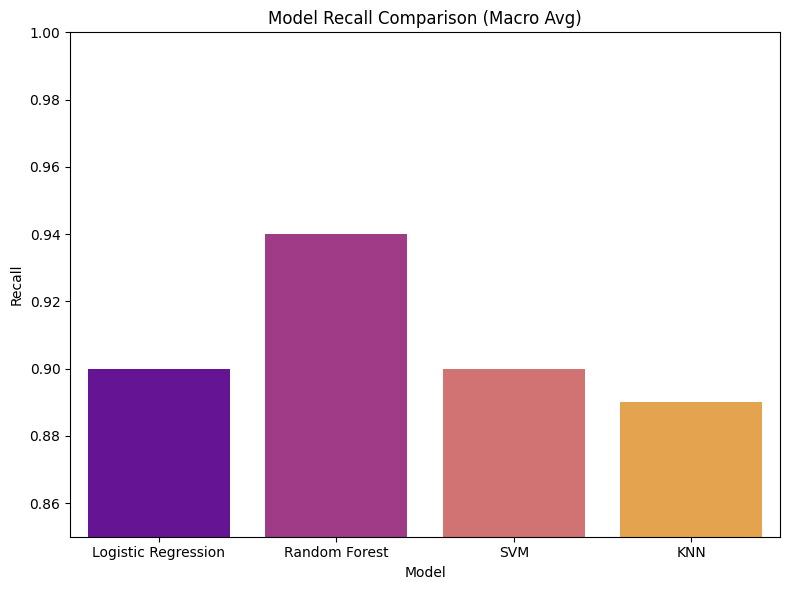

In [103]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Recall (Macro Avg)', data=metrics_df, palette='plasma')
plt.title('Model Recall Comparison (Macro Avg)')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.ylim(0.85, 1.0)  # Adjust as needed
plt.tight_layout()
plt.savefig("recall_comparison.png", dpi=300)
plt.show()


C:\Users\archi\AppData\Local\Temp\ipykernel_20528\201829242.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1-Score (Macro Avg)', data=metrics_df, palette='magma')


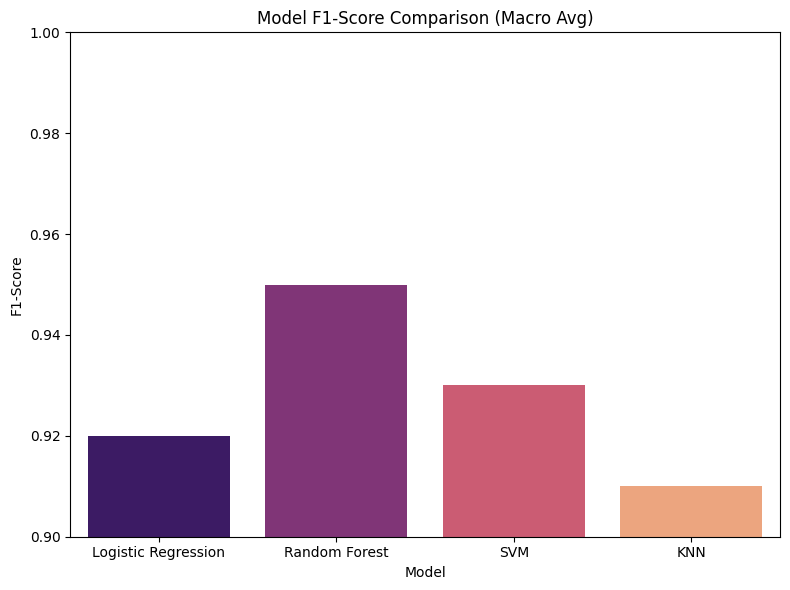

In [104]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='F1-Score (Macro Avg)', data=metrics_df, palette='magma')
plt.title('Model F1-Score Comparison (Macro Avg)')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.ylim(0.90, 1.0)  # Adjust as needed
plt.tight_layout()
plt.savefig("f1score_comparison.png", dpi=300)
plt.show()


In [112]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline with scaling and the best Random Forest model
final_rf_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('rf', grid_rf.best_estimator_)  # This is the best Random Forest from GridSearchCV
])

# Fit the pipeline on the optimal training data
final_rf_pipeline.fit(X_train_opt, y_train)

# Evaluate on the optimal test data
rf_accuracy = final_rf_pipeline.score(X_test_opt, y_test)
print("Final Random Forest Pipeline Accuracy:", rf_accuracy)

# Save the pipeline for later use
joblib.dump(final_rf_pipeline, "final_random_forest_pipeline.pkl")


Final Random Forest Pipeline Accuracy: 0.9752818733738075


['final_random_forest_pipeline.pkl']

In [114]:
import joblib
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create a Voting Classifier that combines the tuned models
voting_clf = VotingClassifier(
    estimators=[
        ('lr', grid_lr.best_estimator_),
        ('rf', grid_rf.best_estimator_),
        ('svm', grid_svm.best_estimator_)
    ],
    voting='soft',         # Use soft voting to combine probabilities
    weights=[1, 2, 1]     # Optionally adjust weights based on performance
)

# Optionally, integrate the voting classifier into a pipeline with scaling
final_ensemble_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('ensemble', voting_clf)
])

# Fit the ensemble pipeline on the optimal training data
final_ensemble_pipeline.fit(X_train_opt, y_train)

# Evaluate on the optimal test data
ensemble_accuracy = final_ensemble_pipeline.score(X_test_opt, y_test)
print("Final Ensemble Pipeline Accuracy:", ensemble_accuracy)

# Save the ensemble pipeline for later use
joblib.dump(final_ensemble_pipeline, "final_voting_pipeline.pkl")


Final Ensemble Pipeline Accuracy: 0.9679098005203816


['final_voting_pipeline.pkl']